# High Energy Photon Cooling

In this notebook, we demonstrate how the high energy photon cooling works and run some cross checks. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

## Load Reference Results

In [3]:
eng_ind = 399

# Check that this matches with the input 

file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]
file_lowengphot = file[1].data['lowengphot'][0,:,:]
file_lowengelec = file[1].data['lowengelec'][0,:,:]

In [4]:
file_highengphot_spectra = Spectra([Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

file_lowengphot_spectra = Spectra([Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_lowengphot, file_rs)])

file_lowengelec_spectra = Spectra([Spectrum(file_eng, elecspec, rs=rs) 
                   for elecspec,rs in zip(file_lowengelec, file_rs)])

## Photon Cooling

Now we cool the photons that result from the high energy photon injection. Photons below 3.1 keV are considered low energy photons. For high energy photons, greater than 3.1 keV, we have transfer functions (a function of *both* injected photon energy and redshift, so they are given as a `TransFuncList`), into high energy photons, low energy photons and low energy electrons. Let's load them first.

In [5]:
user = 'hongwan'

highengphot_tflist = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec.raw", "rb"))
lowengphot_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec.raw", "rb"))
lowengelec_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec.raw", "rb"))
highengphot_tflist_before = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec.raw", "rb"))

# Changes all of the tflists to TransFuncAtRedshift
highengphot_tflist.transpose()
highengphot_tflist_before.transpose()
lowengphot_tflist.transpose()
lowengelec_tflist.transpose()

# This is a list of mwimp values used to generate highengphot_tflist
mwimp_arr = np.array(highengphot_tflist.in_eng)

# This shouldn't be necessary. There is one negative value somewhere. Check.
for tf in highengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 1e-100
for tf in highengphot_tflist_before:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 1e-100
for tf in lowengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 1e-100

## Inputs

In [6]:
eleceng = np.logspace( 1, 13, 500)
# photeng = np.logspace(4, 13, 200)
photeng = highengphot_tflist.in_eng
step = np.log(photeng[1]) - np.log(photeng[0])
test = np.exp(np.arange(np.log(photeng[0]), np.log(9.9e-5), -step))
photeng = np.append(np.flipud(test[1:]), photeng)

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mwimp_arr[eng_ind]]),
                                      photeng)
phot_spec_init.switch_spec_type()

In [7]:
print(photeng.size)

883


We now need to construct a transfer function list for *both* high- and low-energy photons. It needs to be a square matrix (so that we can take powers of the matrix for coarsening later), with dimensions given by the length of `photeng`.

In [8]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 3070]
photeng_low  = photeng[photeng <= 3070]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3500]
eleceng_low  = eleceng[eleceng <= 3500]


# highengphot_tflist.in_eng set to photeng_high

# highengphot_tflist.at_val(
#     '2D_in_eng', 
#     (photeng_high, highengphot_tflist.eng),
#     bounds_error=False, fill_value=1e-100
# )

highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

for tf in highengphot_tflist:
    tf.rebin(photeng_high)
    
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (photeng_low.size, 0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
    tf._rs = tf.rs[0]*np.ones_like(photeng)
    
highengphot_tflist.eng = photeng
highengphot_tflist.in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengphot_tflist:
    tf.rebin(photeng)
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
    tf._rs = tf.rs[0]*np.ones_like(photeng)
lowengphot_tflist.eng = photeng
lowengphot_tflist.in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengelec_tflist:
    tf.rebin(eleceng)
    # Pad with zeros so that it becomes photeng x eleceng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = eleceng
    tf._rs = tf.rs[0]*np.ones_like(photeng)

lowengelec_tflist.eng = eleceng
lowengelec_tflist.in_eng = photeng

In [9]:
print(lowengphot_tflist.in_eng.shape)
print(len(lowengphot_tflist.tflist))

(883,)
50


We need to decide on the redshift step to use. The default redshift step in the transfer functions is $d \log (1+z) = 2 \times 10^{-3}$, with the transfer function evaluated at (currently) 50 redshifts, from $1+z = 30$ to $1+z=4$, so that the transfer function with $d \log(1+z) = 2 \times 10^{-3}$ can be interpolated between them. However, we can coarsen the high energy photon transfer function by some factor $f$ by multiplying the transfer function matrix by itself multiple times, producing transfer functions for a redshift step of $d \log (1+z) = f \times 2 \times 10^{-3}$. 

In [10]:
# The redshift step to use will be coarsen_factor * 0.002
coarsen_factor = 1
# Generate the redshifts at which we want to get an interpolated value for the transfer function. 
tf_rs_arr = highengphot_tflist.rs
rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[1]), 
                           -highengphot_tflist.dlnz*coarsen_factor)
                )

if coarsen_factor > 1:
    lowengphot_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    lowengelec_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    highengphot_tflist.coarsen(coarsen_factor, delete_tfs=False)
    
lowengphot_tflist.at_val('rs',rs_list)
lowengelec_tflist.at_val('rs',rs_list)
highengphot_tflist.at_val('rs',rs_list)
highengphot_tflist_before.at_val('rs', rs_list)

phot_spec_init.rs = rs_list[0]

(883, 883)
(883,)
(883,)
(883,)
(883,)
(883, 500)
(883,)
(500,)
(883,)
(883,)
(883, 883)
(883,)
(883,)
(883,)
(883,)
(500, 500)
(500,)
(500,)
(500,)
(500,)


[100.0, 10000000.0, 1e-20, 10000000000.0]

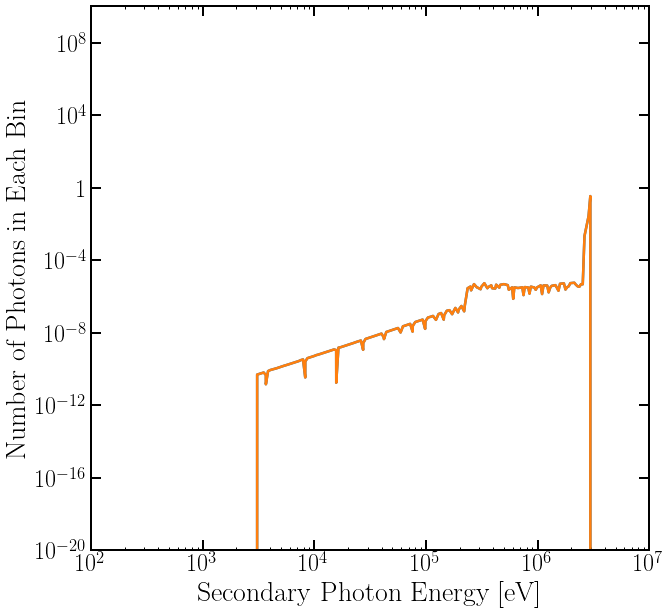

In [12]:
plt.figure()
ax = plt.gca()

eng_plot = 3e6
rs_ind = 20

a = highengphot_tflist_before[rs_ind]
a.rebin(highengphot_tflist.eng)

a.plot(ax, ind=eng_plot, indtype='in_eng')
highengphot_tflist[rs_ind].plot(ax, ind=eng_plot, indtype='in_eng')


ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e2, 1e7, 1e-20, 1e10])

In [13]:
print(highengphot_tflist[0].in_eng)

[1.03448018e-04 1.08201332e-04 1.13173054e-04 1.18373222e-04
 1.23812330e-04 1.29501360e-04 1.35451793e-04 1.41675642e-04
 1.48185469e-04 1.54994415e-04 1.62116224e-04 1.69565272e-04
 1.77356594e-04 1.85505919e-04 1.94029695e-04 2.02945129e-04
 2.12270216e-04 2.22023780e-04 2.32225509e-04 2.42895995e-04
 2.54056777e-04 2.65730384e-04 2.77940379e-04 2.90711408e-04
 3.04069252e-04 3.18040872e-04 3.32654472e-04 3.47939549e-04
 3.63926958e-04 3.80648969e-04 3.98139336e-04 4.16433365e-04
 4.35567983e-04 4.55581813e-04 4.76515256e-04 4.98410565e-04
 5.21311938e-04 5.45265601e-04 5.70319907e-04 5.96525428e-04
 6.23935062e-04 6.52604136e-04 6.82590520e-04 7.13954743e-04
 7.46760114e-04 7.81072853e-04 8.16962222e-04 8.54500664e-04
 8.93763953e-04 9.34831344e-04 9.77785732e-04 1.02271382e-03
 1.06970631e-03 1.11885804e-03 1.17026824e-03 1.22404067e-03
 1.28028388e-03 1.33911140e-03 1.40064198e-03 1.46499981e-03
 1.53231481e-03 1.60272285e-03 1.67636606e-03 1.75339309e-03
 1.83395942e-03 1.918227

In [14]:
highengphot_spectra = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', save_steps=True)
# lowengphot_spectra = spectools.evolve()
# next_phot_spec = spectools.scatter(highengphot_tflist[1], next_phot_spec)
# test2 = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', end_rs = rs_list[2])
# next_low_phot_spec = spectools.scatter(lowengphot_tflist[0], phot_spec_init)
# next_phot_spec = spectools.scatter(highengphot_tflist[2], next_phot_spec)
# test3 = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', end_rs = rs_list[3])
# next_low_phot_spec = spectools.scatter(lowengphot_tflist[0], phot_spec_init)

In [15]:
lowengphot_spectra  = spectools.evolve(
    phot_spec_init, lowengphot_tflist,  
    evolve_type='dep',  prop_tflist=highengphot_tflist, save_steps=True
)

[31.]
[31.         30.93806196]
[31.         30.93806196 30.87624767]
[31.         30.93806196 30.87624767 30.81455689]
[31.         30.93806196 30.87624767 30.81455689 30.75298936]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485
 30.6302231 ]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485
 30.6302231  30.56902387]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485
 30.6302231  30.56902387 30.50794692]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485
 30.6302231  30.56902387 30.50794692 30.446992  ]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485
 30.6302231  30.56902387 30.50794692 30.446992   30.38615887]
[31.         30.93806196 30.87624767 30.81455689 30.75298936 30.69154485
 30.6302231  30.56902387 30.50794692 30.446992   30.38615887 30.32544729]
[31.         30.93806196 30.87624767 30.81

In [16]:
file_highengphot_spectra.rebin(highengphot_spectra.eng)
file_highengphot_spectra.switch_spec_type()
file_lowengphot_spectra.rebin(lowengphot_spectra.eng)
file_lowengphot_spectra.switch_spec_type()

[100.0, 10000000000000.0, 1e-12, 1000.0]

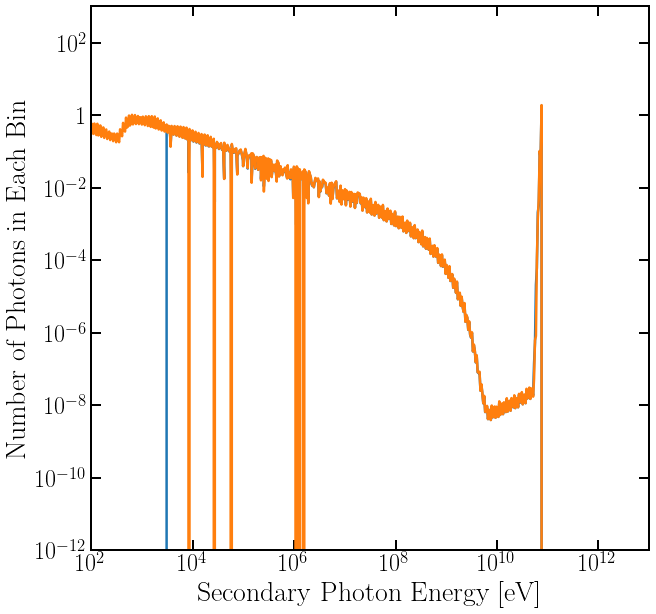

In [17]:
plt.figure()

i_plot = 3

ax = plt.gca()
highengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_highengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
# phot_spectra.plot(ax, ind=rs_list[2], indtype='rs')
# file_spectra.plot(ax, ind=rs_list[2], indtype='rs')
# file_spectra.plot(ax, ind=rs_list[3], indtype='rs')

# file_spectra.plot(ax, ind=rs_list[4], indtype='rs')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e2, 1e13, 1e-12, 1e3])

[0.0001, 4000000.0, 1e-20, 1000.0]

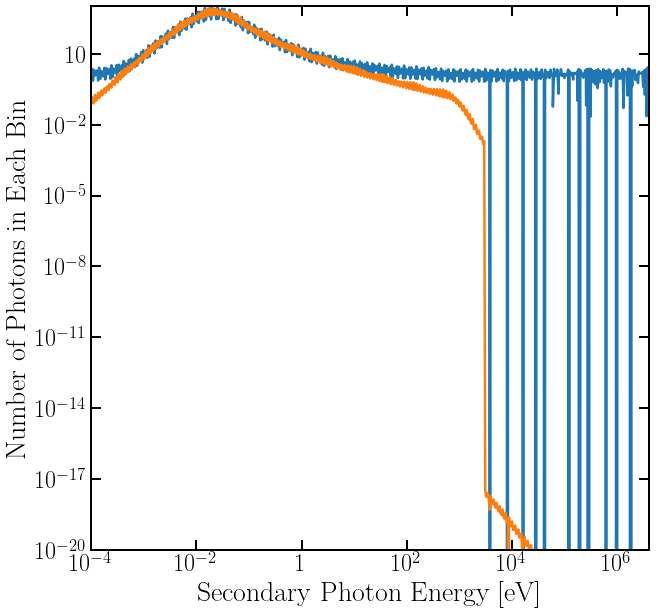

In [28]:
plt.figure()

i_plot = 15

ax = plt.gca()
lowengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_lowengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
# phot_spectra.plot(ax, ind=rs_list[2], indtype='rs')
# file_spectra.plot(ax, ind=rs_list[2], indtype='rs')
# file_spectra.plot(ax, ind=rs_list[3], indtype='rs')

# file_spectra.plot(ax, ind=rs_list[4], indtype='rs')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 4e6, 1e-20, 1e3])

In [20]:
print(highengphot_spectra._grid_vals.shape)
print(lowengphot_spectra._grid_vals.shape)
print(highengphot_spectra.rs.shape)
print(lowengphot_spectra.rs.shape)

(21, 883)
(20, 883)
(21,)
(20,)


In [21]:
for i,rs in enumerate(phot_spectra.rs):
    print(phot_spectra[i].totN())
    print(file_spectra[2*i].totN() - file_spectra[2*i].underflow['N'])

NameError: name 'phot_spectra' is not defined

In [ ]:
utils.compare_arr([
    phot_spectra[0].N, 
    phot_spectra[1].N, 
    file_spectra[2].N,
    phot_spectra[2].N
])

In [ ]:
print(file_spectra.rs[0:10])
print(phot_spectra.rs[0:10])

In [ ]:
print(file_spectra.eng)
print(phot_spectra.eng)